In [1]:
import tensorflow as tf
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras import layers
from keras import backend

In [3]:
from helper_functions import  plot_loss_curves, compare_historys, walk_through_dir

In [4]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [5]:
# walk_through_dir("BasicFinalDatabase")

In [6]:
train_dir = "BanglaLekha/train/"
test_dir = "BanglaLekha/test/"

In [7]:
IMG_SIZE = (224, 224)
train_data_= tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) 

Found 72500 files belonging to 50 classes.
Found 12502 files belonging to 50 classes.


In [8]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  #preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  #preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  #preprocessing.RandomZoom(0.2), # randomly zoom into an image
  preprocessing.Rescaling(1./255) 
], name="data_augmentation")

In [9]:
def conv2dwithbn(x,
              filters,
              kernel_size,
              strides=1,
              padding='same',
              activation='relu',
              use_bias=False,
              name=None):
  """Utility function to apply conv + BN.
  Args:
    x: input tensor.
    filters: filters in `Conv2D`.
    kernel_size: kernel size as in `Conv2D`.
    strides: strides in `Conv2D`.
    padding: padding mode in `Conv2D`.
    activation: activation in `Conv2D`.
    use_bias: whether to use a bias in `Conv2D`.
    name: name of the ops; will become `name + '_ac'` for the activation
        and `name + '_bn'` for the batch norm layer.
  Returns:
    Output tensor after applying `Conv2D` and `BatchNormalization`.
  """
  x = layers.Conv2D(
      filters,
      kernel_size,
      strides=strides,
      padding=padding,
      use_bias=use_bias,
      name=name)(
          x)
  if not use_bias:
    bn_axis = 1 if backend.image_data_format() == 'channels_first' else 3
    bn_name = None if name is None else name + '_bn'
    x = layers.BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
  if activation is not None:
    ac_name = None if name is None else name + '_ac'
    x = layers.Activation(activation, name=ac_name)(x)
  return x

In [10]:
def inception_resnet_block(x, scale, block_type, block_idx, activation='relu'):
  """Adds an Inception-ResNet block.
  This function builds 3 types of Inception-ResNet blocks mentioned
  in the paper, controlled by the `block_type` argument (which is the
  block name used in the official TF-slim implementation):
  - Inception-ResNet-A: `block_type='block35'`
  - Inception-ResNet-B: `block_type='block17'`
  - Inception-ResNet-C: `block_type='block8'`
  Args:
    x: input tensor.
    scale: scaling factor to scale the residuals (i.e., the output of passing
      `x` through an inception module) before adding them to the shortcut
      branch. Let `r` be the output from the residual branch, the output of this
      block will be `x + scale * r`.
    block_type: `'block35'`, `'block17'` or `'block8'`, determines the network
      structure in the residual branch.
    block_idx: an `int` used for generating layer names. The Inception-ResNet
      blocks are repeated many times in this network. We use `block_idx` to
      identify each of the repetitions. For example, the first
      Inception-ResNet-A block will have `block_type='block35', block_idx=0`,
      and the layer names will have a common prefix `'block35_0'`.
    activation: activation function to use at the end of the block (see
      [activations](../activations.md)). When `activation=None`, no activation
      is applied
      (i.e., "linear" activation: `a(x) = x`).
  Returns:
      Output tensor for the block.
  Raises:
    ValueError: if `block_type` is not one of `'block35'`,
      `'block17'` or `'block8'`.
  """
  if block_type == 'block35':
    branch_0 = conv2dwithbn(x, 32, 1)
    branch_1 = conv2dwithbn(x, 32, 1)
    branch_1 = conv2dwithbn(branch_1, 32, 3)
    branch_2 = conv2dwithbn(x, 32, 1)
    branch_2 = conv2dwithbn(branch_2, 48, 3)
    branch_2 = conv2dwithbn(branch_2, 64, 3)
    branches = [branch_0, branch_1, branch_2]
  elif block_type == 'block17':
    branch_0 = conv2dwithbn(x, 192, 1)
    branch_1 = conv2dwithbn(x, 128, 1)
    branch_1 = conv2dwithbn(branch_1, 160, [1, 7])
    branch_1 = conv2dwithbn(branch_1, 192, [7, 1])
    branches = [branch_0, branch_1]
  elif block_type == 'block8':
    branch_0 = conv2dwithbn(x, 192, 1)
    branch_1 = conv2dwithbn(x, 192, 1)
    branch_1 = conv2dwithbn(branch_1, 224, [1, 3])
    branch_1 = conv2dwithbn(branch_1, 256, [3, 1])
    branches = [branch_0, branch_1]
  else:
    raise ValueError('Unknown Inception-ResNet block type. '
                     'Expects "block35", "block17" or "block8", '
                     'but got: ' + str(block_type))

  block_name = block_type + '_' + str(block_idx)
  channel_axis = 1 if backend.image_data_format() == 'channels_first' else 3
  mixed = layers.Concatenate(
      axis=channel_axis, name=block_name + '_mixed')(
          branches)
  up = conv2dwithbn(
      mixed,
      backend.int_shape(x)[channel_axis],
      1,
      activation=None,
      use_bias=True,
      name=block_name + '_conv')

  x = layers.Lambda(
      lambda inputs, scale: inputs[0] + inputs[1] * scale,
      output_shape=backend.int_shape(x)[1:],
      arguments={'scale': scale},
      name=block_name)([x, up])
  if activation is not None:
    x = layers.Activation(activation, name=block_name + '_ac')(x)
  return x

In [11]:
def apakNet(img_input):
    #stem block
    x = conv2dwithbn(img_input, 32, 3, strides=2, padding='valid')
    x = conv2dwithbn(x, 32, 3, padding='valid')
    x = conv2dwithbn(x, 64, 3)
    x = layers.MaxPooling2D(3, strides=2)(x)
    x = conv2dwithbn(x, 80, 1, padding='valid')
    x = conv2dwithbn(x, 192, 3, padding='valid')
    x = layers.MaxPooling2D(3, strides=2)(x)
    #inception block-A
    branch_0 =conv2dwithbn(x, 96, 1)
    branch_1 =conv2dwithbn(x, 48, 1)
    branch_1 =conv2dwithbn(branch_1, 64, 5)
    branch_2 =conv2dwithbn(x, 64, 1)
    branch_2 =conv2dwithbn(branch_2, 96, 3)
    branch_2 =conv2dwithbn(branch_2, 96, 3)
    branch_pool = layers.AveragePooling2D(3, strides=1, padding='same')(x)
    branch_pool =conv2dwithbn(branch_pool, 64, 1)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    channel_axis = 1 if backend.image_data_format() == 'channels_first' else 3
    x = layers.Concatenate(axis=channel_axis, name='mixed_5b')(branches)
    for block_idx in range(1, 3):
        x = inception_resnet_block(
            x, scale=0.17, block_type='block35', block_idx=block_idx)
    branch_0 = conv2dwithbn(x, 384, 3, strides=2, padding='valid')
    branch_1 = conv2dwithbn(x, 256, 1)
    branch_1 = conv2dwithbn(branch_1, 256, 3)
    branch_1 = conv2dwithbn(branch_1, 384, 3, strides=2, padding='valid')
    branch_pool = layers.MaxPooling2D(3, strides=2, padding='valid')(x)
    branches = [branch_0, branch_1, branch_pool]
    x = layers.Concatenate(axis=channel_axis, name='mixed_6a')(branches)
    for block_idx in range(1,5):
        x = inception_resnet_block(
            x, scale=0.1, block_type='block17', block_idx=block_idx)
    branch_0 = conv2dwithbn(x, 256, 1)
    branch_0 = conv2dwithbn(branch_0, 384, 3, strides=2, padding='valid')
    branch_1 = conv2dwithbn(x, 256, 1)
    branch_1 = conv2dwithbn(branch_1, 288, 3, strides=2, padding='valid')
    branch_2 = conv2dwithbn(x, 256, 1)
    branch_2 = conv2dwithbn(branch_2, 288, 3)
    branch_2 = conv2dwithbn(branch_2, 320, 3, strides=2, padding='valid')
    branch_pool = layers.MaxPooling2D(3, strides=2, padding='valid')(x)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    x = layers.Concatenate(axis=channel_axis, name='mixed_7a')(branches)
    for block_idx in range(1, 2):
        x = inception_resnet_block(
            x, scale=0.2, block_type='block8', block_idx=block_idx)
    x = inception_resnet_block(
            x, scale=1., activation=None, block_type='block8', block_idx=2)
    x = conv2dwithbn(x, 1536, 1, name='conv_7b')
    return x

In [12]:
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x=apakNet(x)
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
# flattened_before_dense = layers.Flatten()(x)
dense1 = layers.Dense(1024, activation='relu', name='firstDenseLayer', kernel_regularizer= tf.keras.regularizers.l2(0.001))(x)
dropout1 =layers.Dropout(0.5, name='FirstDropOutLayer')(dense1)
dense2 = layers.Dense(512, activation='relu', name='SecondDenseLayer', kernel_regularizer= tf.keras.regularizers.l2(0.001))(dropout1)
# dropout1 =layers.Dropout(0.5, name='FirstDropOutLayer')(dense2)
dense3 = layers.Dense(256, activation='relu', name='ThirdDenseLayer', kernel_regularizer= tf.keras.regularizers.l2(0.001))(dense2)
        
# dense4 = layers.Dense(128, activation='relu', name='FourthDenseLayer')(dense3)
outputs = layers.Dense(len(train_data_.class_names), activation="softmax", name="output_layer")(dense3)
model = tf.keras.Model(inputs, outputs)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, None, None,   0          ['input_layer[0][0]']            
                                3)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['data_augmentation[0][0]']      
                                32)                                                           

In [14]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, 'apakNet.png', show_shapes=True)

In [15]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(.0001), # use Adam with default settings
              metrics=["accuracy",tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),f1_m])

# Fit
history_1= model.fit(train_data_,
                    epochs=80,
                    batch_size=256,
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)))

Epoch 1/80
2266/2266 [==============================] - 842s 367ms/step - loss: 2.6642 - accuracy: 0.6731 - precision: 0.8687 - recall: 0.5719 - f1_m: 0.6342 - val_loss: 2.3715 - val_accuracy: 0.6536 - val_precision: 0.6701 - val_recall: 0.6272 - val_f1_m: 0.6453
Epoch 2/80
2266/2266 [==============================] - 396s 175ms/step - loss: 1.4133 - accuracy: 0.8854 - precision: 0.9243 - recall: 0.8560 - f1_m: 0.8882 - val_loss: 1.1423 - val_accuracy: 0.9159 - val_precision: 0.9277 - val_recall: 0.9052 - val_f1_m: 0.9153
Epoch 3/80
2266/2266 [==============================] - 315s 139ms/step - loss: 1.0204 - accuracy: 0.9076 - precision: 0.9369 - recall: 0.8864 - f1_m: 0.9106 - val_loss: 0.7651 - val_accuracy: 0.9472 - val_precision: 0.9562 - val_recall: 0.9402 - val_f1_m: 0.9477
Epoch 4/80
2266/2266 [==============================] - 289s 128ms/step - loss: 0.7663 - accuracy: 0.9201 - precision: 0.9447 - recall: 0.9023 - f1_m: 0.9227 - val_loss: 0.6009 - val_accuracy: 0.9477 - val_pr

In [17]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model


391/391 [==============================] - 17s 43ms/step - loss: 0.1525 - accuracy: 0.9810 - precision: 0.9817 - recall: 0.9807 - f1_m: 0.9812


[0.15249784290790558,
 0.9809630513191223,
 0.9817439317703247,
 0.9807230830192566,
 0.9812243580818176]

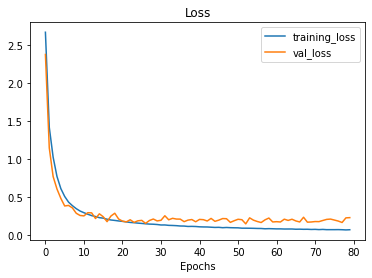

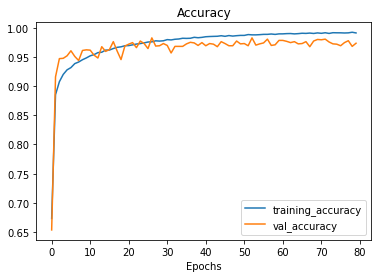

In [18]:
plot_loss_curves(history_1)


In [19]:
model.save('custom_model/')

INFO:tensorflow:Assets written to: custom_model_cmaterDB/assets


INFO:tensorflow:Assets written to: custom_model_cmaterDB/assets
